In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import segmentation_models_pytorch as sm
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from sklearn.model_selection import train_test_split
import albumentations as A
import os
from tqdm.notebook import tqdm

import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from tqdm import tqdm

from torchsummary import summary

In [3]:
# Segformer
model = sm.Segformer('mit_b2', encoder_weights='imagenet', classes=37, activation=None)

# load checkpoint
model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map_location=device))

/tmp/ipykernel_6028/2231299292.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map

<All keys matched successfully>

In [4]:
# show layers
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,472
         LayerNorm-2         [-1, 64, 128, 128]             128
 OverlapPatchEmbed-3         [-1, 64, 128, 128]               0
         LayerNorm-4            [-1, 16384, 64]             128
            Linear-5            [-1, 16384, 64]           4,160
            Conv2d-6           [-1, 64, 16, 16]         262,208
         LayerNorm-7              [-1, 256, 64]             128
            Linear-8             [-1, 256, 128]           8,320
           Dropout-9        [-1, 1, 16384, 256]               0
           Linear-10            [-1, 16384, 64]           4,160
          Dropout-11            [-1, 16384, 64]               0
        Attention-12            [-1, 16384, 64]               0
         Identity-13            [-1, 16384, 64]               0
        LayerNorm-14            [-1, 16

In [5]:
print(model)

Segformer(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_featur

In [9]:
import torchvision.transforms as T

# mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# show feature embedding for this picture per pixel
img = cv.imread('dataset/images/0.jpg')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img, (512, 512))

t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])

img = t(img)

img = img.unsqueeze(0) # add batch dimension

print(img.shape)

output = model(img)

print(output.shape)

#output = output.squeeze(0)
# Softmax
output = F.softmax(output, dim=1)

print(output.shape)

output = torch.argmax(output, dim=1)

print(output.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 37, 512, 512])
torch.Size([1, 37, 512, 512])
torch.Size([1, 512, 512])


In [10]:
encoder = model.encoder

In [11]:
with torch.no_grad():
    feature_maps = encoder(img)
    print(f"Number of feature maps: {len(feature_maps)}")

for i in feature_maps:
    print(i.shape)


Number of feature maps: 6
torch.Size([1, 3, 512, 512])
torch.Size([1, 0, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 320, 32, 32])
torch.Size([1, 512, 16, 16])


In [15]:
selected_feature_map = feature_maps[2]

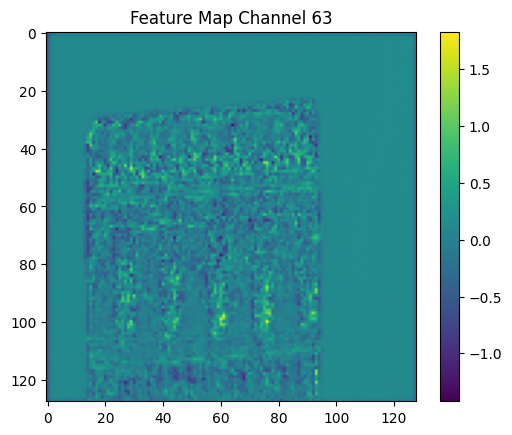

In [16]:
# Visualize a specific channel (e.g., channel 0)
channel = 63  # You can change this to any channel number

plt.imshow(selected_feature_map[0, channel, :, :].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title(f"Feature Map Channel {channel}")
plt.show()

In [17]:
# Find embedding for a specific pixel
def retrieve_embedding(feature_maps, x, y):
    embedding = []
    scale = 2

    # All Transformer blocks (OUTPUTS)
    for idx, features in enumerate(feature_maps):

        if features.shape[0] == 0:
            continue

        # Scale down coordinates
        scaled_x = int(x // (scale**idx))
        scaled_y = int(y // (scale**idx))

        # Append the embedding
        pixel_embedding = features[0, :, scaled_x, scaled_y].cpu().numpy()
        embedding.append(pixel_embedding)

    return np.concatenate(embedding) 

In [18]:
embedding = retrieve_embedding(feature_maps, 500, 100)
print(len(embedding))

1027


In [19]:
def get_feature_map(image_path, encoder):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (512, 512))
    t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])
    img = t(img)
    img = img.unsqueeze(0) # add batch dimension
    with torch.no_grad():
        feature_maps = encoder(img)
    return feature_maps

In [25]:
def get_predictions(image_path, model):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (512, 512))
    t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])
    img = t(img)
    img = img.unsqueeze(0) # add batch dimension
    with torch.no_grad():
        output = model(img)
    output = torch.argmax(F.softmax(output, dim=1), dim=1) # softmax: om logits --> probabilities --> klasse index
    return output

In [26]:
predictions = get_predictions('dataset/images/0.jpg', model)

In [27]:
def create_df():
    name = []
    filenames = os.listdir("dataset/images")
    filenames = sorted(filenames, key=lambda x : int(x.split('.')[0]))
    for filename in filenames:
        name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [28]:
df = create_df()

X_train, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19) # split the data into train and test sets
X_train, X_val = train_test_split(X_train, test_size=0.15, random_state=19) # validate on 15% of the training data

In [24]:
# Read classes json
import json

with open('obj_class_to_machine_color.json', 'r') as f:
    classes = json.load(f)

# List of classes
class_labels = []
for key, value in classes.items():
    class_labels.append(key)

print(len(class_labels))

important_classes = [
        'Ionic kyma decoration', 
        'Lesbian kyma decoration', 
        'Bead-and-reel (double double)', 
        'Scroll pattern (large)', 
        'Anthemion (large & capital & pulvinus)', 
        'Anthemion (small & soffit & top moulding architrave)', 
        'Acanthus leaves (solo) (capital & frieze & modillion)'
    ]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

36


### Calculate per image the average embedding for each important class.

In [29]:
# Segformer
model = sm.Segformer('mit_b2', encoder_weights='imagenet', classes=37, activation=None)

# load checkpoint
model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map_location=device))

encoder = model.encoder

/tmp/ipykernel_6028/1628315217.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map

In [ ]:
import numpy as np

global_label_embeddings = {}

# Go through all test images
for img_name in X_test:
    output_pred = get_predictions(f'dataset/images/{img_name}.jpg', model)
    feature_maps = get_feature_map(f'dataset/images/{img_name}.jpg', encoder)

    unique_labels = np.unique(output_pred.numpy()) # Get unique labels in the prediction

    for label in tqdm(unique_labels):
        if label in labels_import_classes:  # Only consider important classes
            # Get X and Y coordinates of all pixels with current important label
            x, y = np.where(output_pred.numpy()[0] == label) 

            if len(x) == 0:
                continue

            label_embeddings = []
            
            # Retrieve the embedding for each pixel with the current label
            for i in range(len(x)):
                pixel_embedding = retrieve_embedding(feature_maps, x[i], y[i])
                label_embeddings.append(pixel_embedding)
                
            # Calculate the mean embedding for the label in this image
            label_embeddings = np.array(label_embeddings)  # Convert to NumPy array
            mean_embedding = np.mean(label_embeddings, axis=0)
            
            # Add the mean embedding to the global dictionary
            if label not in global_label_embeddings:
               global_label_embeddings[label] = []
            global_label_embeddings[label].append(mean_embedding)

    print(f"Processed image: {img_name}")
      

 33%|███▎      | 2/6 [00:03<00:07,  1.84s/it]

(1027,)


 50%|█████     | 3/6 [00:10<00:11,  3.75s/it]

(1027,)


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]

(1027,)
Processed image: 37



 14%|█▍        | 1/7 [00:01<00:08,  1.38s/it]


KeyboardInterrupt: 

In [24]:
print(global_label_embeddings.keys())

print(len(global_label_embeddings.values()))

print(len(global_label_embeddings[1]))

dict_keys([np.int64(1), np.int64(2), np.int64(6), np.int64(15), np.int64(29), np.int64(12), np.int64(30)])
7
33


['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green', 'green', 'green', 'green', 'green', 'gre

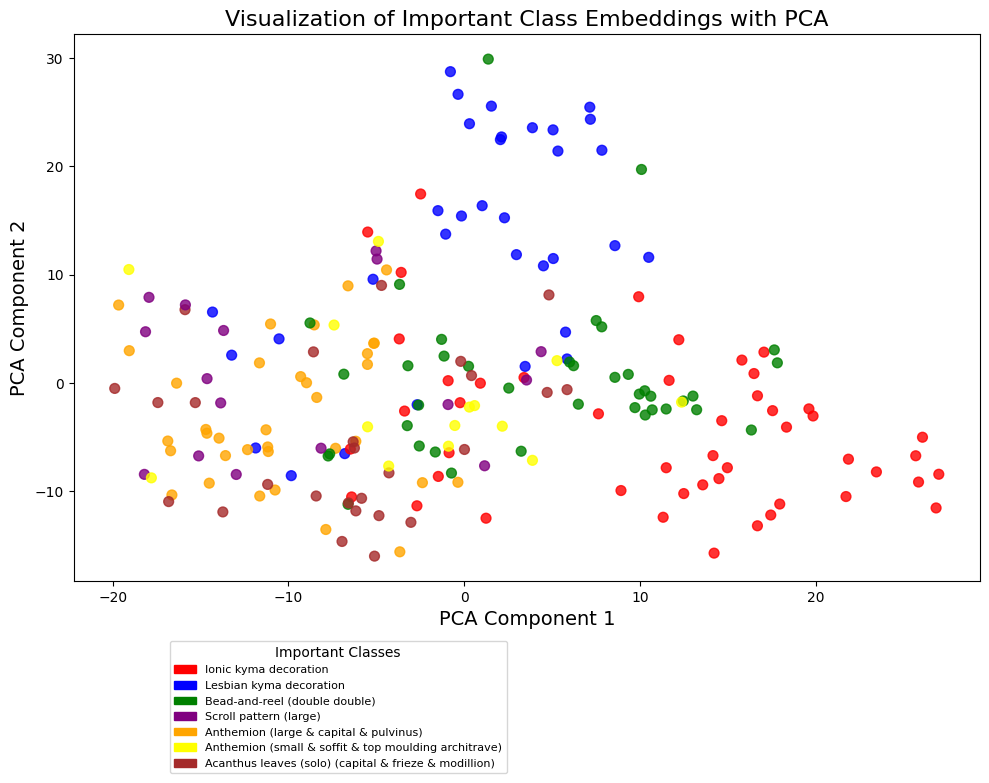

In [35]:
from sklearn.decomposition import PCA


# List of important classes and their corresponding labels
important_classes = [
    'Ionic kyma decoration', 
    'Lesbian kyma decoration', 
    'Bead-and-reel (double double)', 
    'Scroll pattern (large)', 
    'Anthemion (large & capital & pulvinus)', 
    'Anthemion (small & soffit & top moulding architrave)', 
    'Acanthus leaves (solo) (capital & frieze & modillion)'
]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

# Create a mapping of class labels to specific colors (you can change these colors)
color_map = {
    6: 'red',
    1: 'blue',
    15: 'green',
    12: 'purple',
    2: 'orange',
    30: 'yellow',
    29: 'brown'
}

# Combine embeddings into a single array and track labels
embeddings = []
labels = []

for label, arrays in global_label_embeddings.items():
    for arr in arrays:
        embeddings.append(arr)  # Add embedding
        labels.append(label)    # Add corresponding 

embeddings = np.vstack(embeddings)  # Combine into 2D array

# Reduce dimensions with PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# Create color array for each label
colors = [color_map.get(label) for label in labels]  # Default color 'gray' for non-important labels
print(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, s=50, alpha=0.8)

# Create a legend   
import matplotlib.patches as mpatches

legend_labels = [mpatches.Patch(color=color_map[label], label=important_classes[i]) for i, label in enumerate(labels_import_classes)]

plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(0.1, -0.1), title="Important Classes", fontsize=8)

plt.title("Visualization of Important Class Embeddings with PCA", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)

# Adjust layout to fit the plot and legend
plt.tight_layout()

plt.show()


/home/tenzing/apollo/avc/projects/archaeology/.myvenv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green', 'green', 'green', 'green', 'green', 'gre

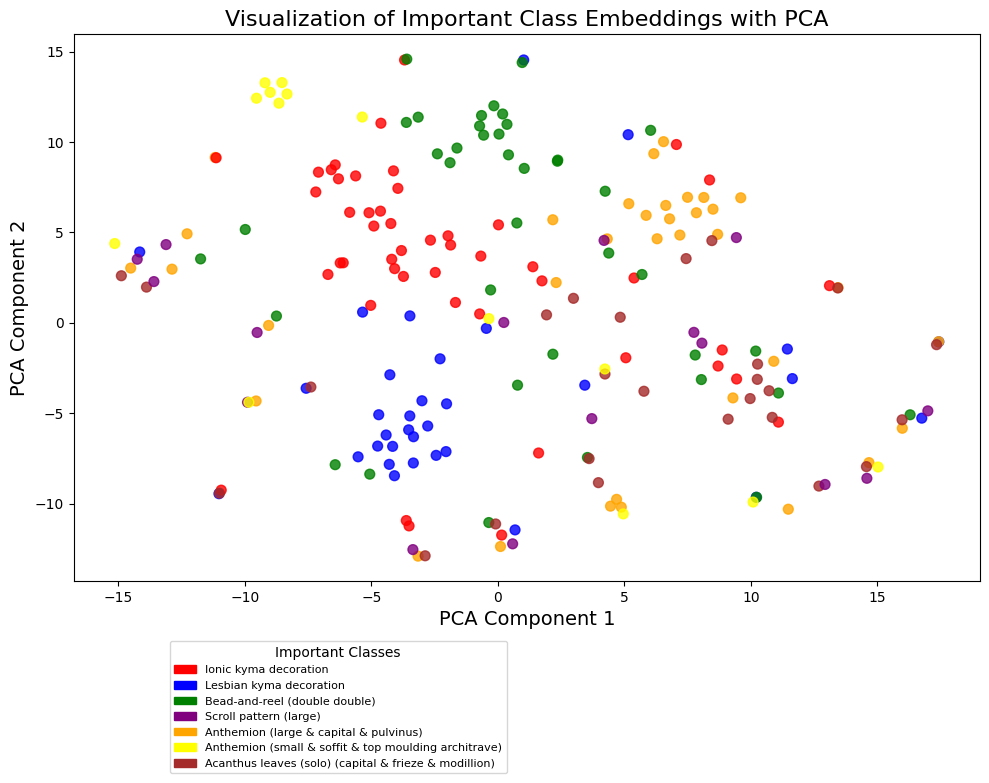

In [38]:
# Initialize TSNE
from sklearn.manifold import TSNE


# List of important classes and their corresponding labels
important_classes = [
    'Ionic kyma decoration', 
    'Lesbian kyma decoration', 
    'Bead-and-reel (double double)', 
    'Scroll pattern (large)', 
    'Anthemion (large & capital & pulvinus)', 
    'Anthemion (small & soffit & top moulding architrave)', 
    'Acanthus leaves (solo) (capital & frieze & modillion)'
]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

# Create a mapping of class labels to specific colors (you can change these colors)
color_map = {
    6: 'red',
    1: 'blue',
    15: 'green',
    12: 'purple',
    2: 'orange',
    30: 'yellow',
    29: 'black'
}

# Combine embeddings into a single array and track labels
embeddings = []
labels = []

for label, arrays in global_label_embeddings.items():
    for arr in arrays:
        embeddings.append(arr)  # Add embedding
        labels.append(label)    # Add corresponding 

embeddings = np.vstack(embeddings)  # Combine into 2D array

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)


pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_pca)


# Create color array for each label
colors = [color_map.get(label) for label in labels]  # Default color 'gray' for non-important labels
print(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, s=50, alpha=0.8)

# Create a legend   
import matplotlib.patches as mpatches

legend_labels = [mpatches.Patch(color=color_map[label], label=important_classes[i]) for i, label in enumerate(labels_import_classes)]

plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(0.1, -0.1), title="Important Classes", fontsize=8)

plt.title("Visualization of Important Class Embeddings with PCA", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)

# Adjust layout to fit the plot and legend
plt.tight_layout()

plt.show()